# Создание модели для определения возраста по фото

В ходе проекта необхдоимо создать модель, определяющую возраст человека на фотографии.
<br> В качестве датасета используется APPA-REAL Dataset, который содержит примеры  фотографий и соответствующий им возраст.
<br> В качестве метрики эффективности модели будет использована метрика MAE - ее значение после обучения не должно превышать значение 7.
<br> В качестве основы модели будет использована ResNet50  с последующим созданием дополнительных слоев.

План работы:

1. Исследовательский анализ данных
    - Подготовка данных
    - Изучение размеров выборки
    - Изучение графика распределения возрастов
    - Изучение примеров фотографий
2. Моделирование
    - Создание функций для загрузки данных, создания и обучения модели
    - Запуск обучения
    - Анализ результатов метрики MAE
3. Общий вывод 

## Исследовательский анализ данных

### Подготовка данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np


PATH_MAIN='/datasets/faces/'
PATH_ADD_IMG = '/final_files'
PATH_ADD_TARGET = 'labels.csv'
RANDOM_STATE = 12345

In [2]:
target_data = pd.read_csv(PATH_MAIN+PATH_ADD_TARGET)

In [3]:
target_data.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


Целевые признаки загружены в датафрейм.

In [4]:
datagen = ImageDataGenerator()
datagen_flow = datagen.flow_from_dataframe(
    dataframe=target_data,
    directory=PATH_MAIN+PATH_ADD_IMG,
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    save_format='jpg',
    seed=RANDOM_STATE
)

Found 7591 validated image filenames.


Загружено 7591 изображение. Рассмотрим пример.

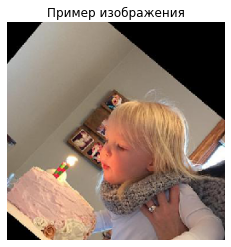

In [5]:
plt.imshow(datagen_flow[224][0][0]/255) 
plt.title('Пример изображения')
plt.axis('off')
plt.show()

Определим возраст выбранной фотогргафии:

In [6]:
print('Человеку на фотографии выше:',datagen_flow[224][1][0],'года/лет.')

Человеку на фотографии выше: 2 года/лет.


**Вывод:** загружена библиотека фотографий (7591 фото) и каждое фото сопоставлено с соответствующим ей возрастом. Также выведен пример фотографии и возраста для проверки корректности загрузки.

### Изучим размер выборки

In [7]:
target_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
print(target_data.shape)

(7591, 2)


Видим, что в выборке 7591 пример с лицом и соответствующим возрастом.
<br>Таргетные значения хранятся в соответствующем формате и не содержат пропусков.

### Изучим график распределения возраста

In [9]:
target_data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


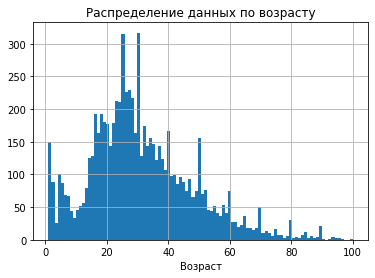

In [10]:
target_data.hist(bins=100)
plt.title('Распределение данных по возрасту')
plt.xlabel('Возраст')
#plt.уlabel('Кол-во примеров фотографий')
plt.show()

Видим, что:
- минимальный возраст - 1 год, максимальный - 100 лет.
- медиана по возрасту - 29 лет, среднее - 31год. 
Распределение приближенно похоже на нормальное, но скошено влево. 
<br> При этом в районе возраста 10 лет видим провал в данных относительно соседних возрастов. 
<br>То есть, данных по 10летним детям немного относительно, например, 20-летних людей.
<br>Но у нас есть много детских фотографий - это хорошо, так как в возрасте до 10 лет лица меняются очень быстро и образцов должно быть достаточно, если мы хотим, чтобы модель была хорошего качества. 


### Рассмотрим примеры фотографий

Рассмотрим примеры фотографий нескольких людей:

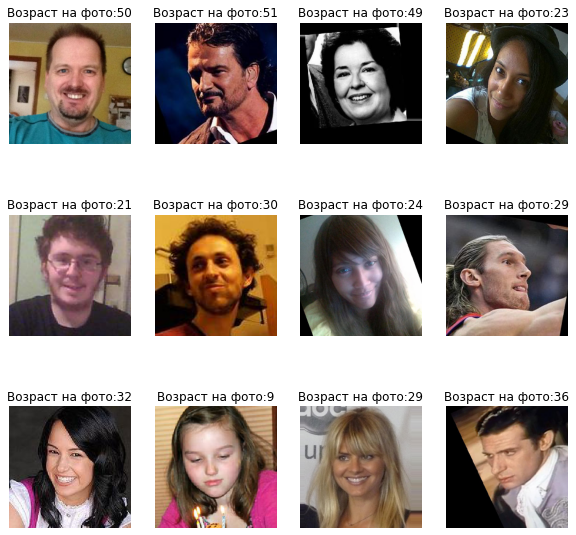

In [11]:
fig, axes = plt.subplots(nrows = 3, ncols=4, figsize = (10,10))
i=0
k=0
for i in range(0,3):
    for k in range(0,4):
        axes[i,k].imshow(datagen_flow[i*4+k][0][0]/255) 
        axes[i,k].set_title('Возраст на фото:'+str(datagen_flow[i*4+k][1][0]))
        axes[i,k].axis('off')
        k=k+1
    i=i+1

Примеры фотографий просмотрели.

**Вывод**:
В ходе анализа датасета удалось выяснить:
- датасет содержит 7591 фотографию с возрастом. 
- возраст хранится в числовом формате и не содержит отсутствующих значений.
- минимальный возраст - 1 год, максимальный - 100 лет.
- медиана по возрасту - 29 лет, среднее - 31год. 
Распределение приближенно похоже на нормальное, но скошено влево. 
<br>При этом в районе возраста 10 лет видим провал в данных относительно соседних возрастов. 
То есть, данных по 10летним детям немного относительно, например, 20-летних людей.

По распределению данных видим, что количество примеров для возраста 18-40 гораздо больше, чем для возрастов старше или младше этого диапазона. Поэтому, после обучения модель может хорошо угадывать лица 18-40 лет, но чем дальше человек на фото от заданного диапазона возраста, тем менее точным может быть предсказание.

## Моделирование

### Создание и обучение модели

Создадим функции для загрузки данных и обучения модели:

In [ ]:
# from tensorflow.keras.models import Sequential
# import pandas as pd
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt
# import numpy as np
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.resnet import ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

def load_train(path):   
    
    target_data = pd.read_csv(path+'/labels.csv')
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=target_data,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        save_format='jpg',
        target_size=(224,224),
        subset='training',
        seed=12345
    )
    return datagen_flow

def load_test(path):   
    target_data = pd.read_csv(path+'/labels.csv')
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=target_data,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        save_format='jpg',
        target_size=(224,224),
        subset='validation',
        seed=12345
    )
    return datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                            weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                            #weights='imagenet',
                            include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear')) 
    model.summary()
        
    optimizer = Adam(learning_rate=0.0003)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
          validation_data = test_data,
          batch_size=batch_size,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2, epochs=epochs)


    return model 

Запуск модели:

In [ ]:
train_data = load_train(path)
test_data = load_test(path)

model = create_model(input_shape = (224, 224, 3))

model = train_model(model, train_data, test_data,  32, 10, 178, 60)

Результаты обучения:

Train for 178 steps, validate for 60 steps
<br>Epoch 1/10
<br>178/178 - 46s - loss: 192.1662 - mae: 10.2155 - val_loss: 336.7652 - val_mae: 13.6104
<br>Epoch 2/10
<br>178/178 - 38s - loss: 76.9689 - mae: 6.6736 - val_loss: 386.7731 - val_mae: 14.6435
<br>Epoch 3/10
<br>178/178 - 40s - loss: 44.0569 - mae: 5.1129 - val_loss: 351.4206 - val_mae: 13.9616
<br>Epoch 4/10
<br>178/178 - 39s - loss: 28.5297 - mae: 4.0796 - val_loss: 161.8115 - val_mae: 9.3673
<br>Epoch 5/10
<br>178/178 - 38s - loss: 20.6922 - mae: 3.5338 - val_loss: 88.5093 - val_mae: 7.1324
<br>Epoch 6/10
<br>178/178 - 38s - loss: 15.0812 - mae: 3.0133 - val_loss: 71.4997 - val_mae: 6.4279
<br>Epoch 7/10
<br>178/178 - 38s - loss: 10.8717 - mae: 2.5333 - val_loss: 119.4355 - val_mae: 8.7872
<br>Epoch 8/10
<br>178/178 - 38s - loss: 10.1869 - mae: 2.4296 - val_loss: 75.6788 - val_mae: 6.7605
<br>Epoch 9/10
<br>178/178 - 39s - loss: 10.0870 - mae: 2.4112 - val_loss: 67.9947 - val_mae: 6.2946
<br>Epoch 10/10
<br>178/178 - 39s - loss: 9.1965 - mae: 2.3147 - val_loss: 68.7368 - **val_mae: 6.3476**

Удалось добиться метрики MAE=6.3 (MAE<7), значит модель хорошо справляется с предсказанием возраста на тестовой выборке.

**Вывод**: при построении модели для предсказания возраста по фотографии была использована архитектура ResNet50 с удалением верхнего слоя и добавлением двух дополнительных слоев:
- пуллинг GlobalAveragePooling2D
- финальный полносвязный Dense-слой с одним выходным нейроном и функцией активации 'linear' (т.к. стояла задача регрессии) 
Также в качестве потерь была выбрана метрика MSE, а в качестве финальной метрики - MAE.

Именно эта архитектура позволила достичь метрики MAE<7.

## Общий вывод

Задачей проекта был анализ исходных данных (фотографии с реальным возрастом людей на фото) и создание модели для предсказания возраста на фотографии.
В ходе проекта было сделано:

**Проанализирован исходный набор данных:**
- загружена библиотека фотографий и каждое фото сопоставлено с соответствующим ей возрастом. 
- датасет содержит 7591 фотографию с возрастом. 
- возраст хранится в числовом формате и не содержит отсутствующих значений.
- минимальный возраст в выборке - 1 год, максимальный - 100 лет.
- медиана по возрасту  в выборке - 29 лет, среднее - 31год. 
<br>Также выведены примеры фотографии и возраста для проверки корректности загрузки.
<br>Распределение приближенно похоже на нормальное, но скошено влево. 
<br> При этом в районе возраста 10 лет видим провал в данных относительно соседних возрастов. 
<br>То есть, данных по 10летним детям немного относительно, например, 20-летних людей.
<br>Но у нас есть много детских фотографий - это хорошо, так как в возрасте до 10 лет лица меняются очень быстро и образцов должно быть достаточно, если мы хотим, чтобы модель была хорошего качества. 

**В ходе разработки модели:**
- разработаны функции загрузки данных, создания и обучения модели:
    - load_train
    - load_test
    - create_model
    - train_model
<br>При построении модели для предсказания возраста по фотографии была использована архитектура ResNet50 с удалением верхнего слоя и добавлением двух дополнительных слоев:
- пуллинг GlobalAveragePooling2D
- финальный полносвязный Dense-слой с одним выходным нейроном и функцией активации 'linear' (т.к. стояла задача регрессии) 
<br>Также в качестве потерь была выбрана метрика MSE, а в качестве финальной метрики - MAE.
<br>Именно эта архитектура позволила достичь метрики MAE<7.

**<br>Финальная метрика на валидационной выборке составила: MAE=6.3**
